# Sea Ice Validation for ACCESS-OM2_01

Author: Andrew Kiss; heavily based on Adele Morrison's "Ice Validation mom025"

In [3]:
%matplotlib inline

from glob import glob
import os,sys
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
from tqdm import tqdm_notebook
from mpl_toolkits.basemap import Basemap
from calendar import month_abbr

In [4]:
with_turning = False  # whether to just use the early runs that had nonzero ice turning angle
figdir = ''
def savefigure(fname):
#     plt.savefig(os.path.join(figdir, fname),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [5]:
# model data paths:
model = 'access-om2-01'
DataDir = '/g/data3/hh5/tmp/cosima/' + model + '/'
expt = '01deg_jra55v13_ryf8485_spinup6'
expdir = os.path.join(DataDir, expt)

# sea ice observation data paths:
obsVersion = 3
if obsVersion==3:
    ObsDir = '/g/data1a/v45/aek156/data/NOAA/G02202_V3'  # from http://nsidc.org/data/G02202
    ObsDirExt = '/g/data1a/v45/aek156/data/NOAA/G02135'  # from http://nsidc.org/data/g02135
else:
# v2
    ObsDir = '/g/data/v45/akm157/data/NSIDC/NOAA_G02202_v2_conc_monthly/'
    ObsDirExt = '/g/data/v45/akm157/data/NSIDC/NOAA_G02135_extent_monthly/' # v2.1

# length of climatology (may be corrected below):
if with_turning:
    n_years = 5
else:
    n_years = 10

# path to model sea ice data:
dataFileList = glob(os.path.join(expdir, 'output*/ice/OUTPUT/iceh.????-??.nc'))  # monthly
dataFileList.sort()
if with_turning:
    dataFileList = dataFileList[:113] # cosw=1.0, sinw=0.0, ie turning angle of 0, from start of Aug year 12 (run 113)

dataFileListDaily = glob(os.path.join(expdir, 'output*/ice/OUTPUT/iceh.????-??-??.nc'))  # daily
dataFileListDaily.sort()

# update n_years to avoid exceeding available data
if model=='mom025':
    filesPerYear = 1
elif model=='mom01v5':
    filesPerYear = 4
elif model=='access-om2-01':
    filesPerYear = 12
total_years = len(dataFileList)/filesPerYear  # NB: typically not an integer
n_years = min(n_years, int(total_years) )
n_files = n_years*filesPerYear
firstfile = int(total_years-n_years)*filesPerYear  # start of calendar year

# paths to obs data:
if obsVersion==3:
    obsNHFileList = glob(os.path.join(ObsDir, 'north/monthly/*.nc'))
    obsSHFileList = glob(os.path.join(ObsDir, 'south/monthly/*.nc'))
    obsExtNHFileList = glob(os.path.join(ObsDirExt, 'north/monthly/data/*.csv'))
    obsExtSHFileList = glob(os.path.join(ObsDirExt, 'south/monthly/data/*.csv'))
else:
    obsNHFileList = glob(os.path.join(ObsDir, 'nh/*.nc'))
    obsSHFileList = glob(os.path.join(ObsDir, 'sh/*.nc'))
    obsExtNHFileList = glob(os.path.join(ObsDirExt, 'nh/*.csv'))
    obsExtSHFileList = glob(os.path.join(ObsDirExt, 'sh/*.csv'))

obsNHFileList.sort()
obsSHFileList.sort()
obsExtNHFileList.sort()
obsExtSHFileList.sort()

font = {'size':13}
tick_font=13

In [6]:
# get model grid data:
gridFileList = glob(os.path.join(expdir, 'output*/ocean/ocean_grid.nc'))
gridFileList.sort()
ncFile = nc.Dataset(gridFileList[0])
xt_ocean = ncFile.variables['xt_ocean'][...]
yt_ocean = ncFile.variables['yt_ocean'][...]
lon_t = ncFile.variables['geolon_t'][...]
lat_t = ncFile.variables['geolat_t'][...]
area_t = ncFile.variables['area_t'][...]
NLAT_half = int(np.shape(area_t)[0]/2)
ht = ncFile.variables['ht'][...]
land_mask = np.copy(ht)
land_mask[np.where(ht>30)] = 0
land_mask[np.where(ht<=30)] = 1

## Sea ice volume timeseries, broken down by category
vicen_m(time, nc, nj, ni)
		has units = "m" ;
so need to multiply by area to get volume.
nc is number of ice categories.

In [7]:
# Warning - slow! 
# TODO: try to accelerate this with dask somehow

ncFile = nc.Dataset(dataFileList[0])
HI = ncFile.variables['vicen_m'][...]
n_cats = HI.shape[1]  # number of ice categories

#  init lists of n_cats+1 empty lists (extra one for total)
NH_ice_volume = [[] for _ in range(n_cats+1)]
SH_ice_volume = [[] for _ in range(n_cats+1)]
time = []
for IceFile in tqdm_notebook(dataFileList, leave=False):
    ncFile = nc.Dataset(IceFile)
    HI = ncFile.variables['vicen_m'][...]
    time_temp = ncFile.variables['time'][...]
    time = np.append(time,time_temp)
    for c in range(n_cats):
        volume_temp = np.sum(HI*area_t,axis=-1)  # zonal sum
        NH_ice_volume[c] = np.append(NH_ice_volume[c],np.sum(volume_temp[:,c,NLAT_half:],axis=-1))
        SH_ice_volume[c] = np.append(SH_ice_volume[c],np.sum(volume_temp[:,c,:NLAT_half],axis=-1))
    
# totals
NH_ice_volume[c+1] = np.sum(NH_ice_volume[:n_cats],axis=0)
SH_ice_volume[c+1] = np.sum(SH_ice_volume[:n_cats],axis=0)

# do annual averages:
n_yrs_total = int(total_years)
NH_annual_volume = [np.zeros(n_yrs_total) for _ in range(np.shape(NH_ice_volume)[0])]
SH_annual_volume = [np.zeros(n_yrs_total) for _ in range(np.shape(NH_ice_volume)[0])]
time_annual = np.zeros(n_yrs_total)
for year in range(n_yrs_total):
    time_annual[year] = np.mean(time[year*12:(year+1)*12])
    for c in range(np.shape(NH_ice_volume)[0]):
        NH_annual_volume[c][year] = np.mean(NH_ice_volume[c][year*12:(year+1)*12])
        SH_annual_volume[c][year] = np.mean(SH_ice_volume[c][year*12:(year+1)*12])

HBox(children=(IntProgress(value=0, max=384), HTML(value='')))

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/numpy/ma/core.py:1016: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


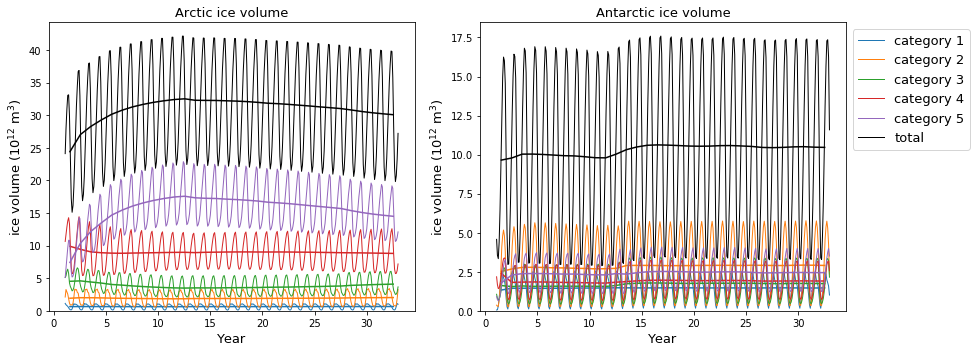

In [8]:
plt.figure(1,(12,5))
plt.clf()

plt.subplot(1,2,1)
for c in range(n_cats):
    plt.plot(time/365+1,NH_ice_volume[c]/1e12, color='C'+str(c), label='category '+str(c+1), linewidth=1)
    plt.plot(time_annual/365+1,NH_annual_volume[c]/1e12, color='C'+str(c))
plt.plot(time/365+1,NH_ice_volume[c+1]/1e12, color='k', label='total', linewidth=1)
plt.plot(time_annual/365+1,NH_annual_volume[c+1]/1e12, color='k')
plt.ylim(ymin=0)
plt.xlabel('Year',font)
plt.ylabel(r'ice volume (10$^{12}$ m$^3$)',font)
plt.title('Arctic ice volume',font)

plt.subplot(1,2,2)
for c in range(n_cats):
    plt.plot(time/365+1,SH_ice_volume[c]/1e12, color='C'+str(c), label='category '+str(c+1), linewidth=1)
    plt.plot(time_annual/365+1,SH_annual_volume[c]/1e12, color='C'+str(c))
plt.plot(time/365+1,SH_ice_volume[c+1]/1e12, color='k', label='total', linewidth=1)
plt.plot(time_annual/365+1,SH_annual_volume[c+1]/1e12, color='k')
plt.ylim(ymin=0)
plt.xlabel('Year',font)
plt.ylabel(r'ice volume (10$^{12}$ m$^3$)',font)
plt.title('Antarctic ice volume',font)
plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

savefigure('ice_volume_categories')

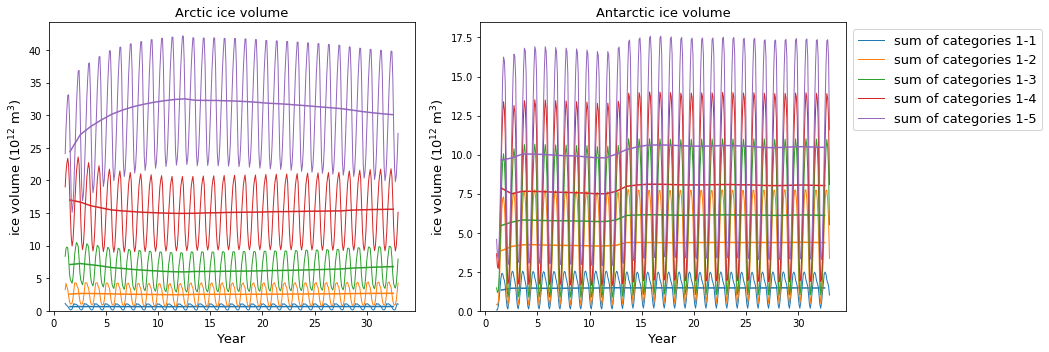

In [9]:
plt.figure(1,(12,5))
plt.clf()

plt.subplot(1,2,1)
for c in range(n_cats):
    plt.plot(time/365+1,np.sum(NH_ice_volume[:c+1],axis=0)/1e12, color='C'+str(c), linewidth=1)
    plt.plot(time_annual/365+1,np.sum(NH_annual_volume[:c+1],axis=0)/1e12, color='C'+str(c))
plt.ylim(ymin=0)
plt.xlabel('Year',font)
plt.ylabel(r'ice volume (10$^{12}$ m$^3$)',font)
plt.title('Arctic ice volume',font)

plt.subplot(1,2,2)
for c in range(n_cats):
    plt.plot(time/365+1,np.sum(SH_ice_volume[:c+1],axis=0)/1e12, color='C'+str(c), label='sum of categories 1-'+str(c+1), linewidth=1)
    plt.plot(time_annual/365+1,np.sum(SH_annual_volume[:c+1],axis=0)/1e12, color='C'+str(c))
plt.ylim(ymin=0)
plt.xlabel('Year',font)
plt.ylabel(r'ice volume (10$^{12}$ m$^3$)',font)
plt.title('Antarctic ice volume',font)
plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

savefigure('ice_volume_categories_cumulative')

So the growth of Arctic ice volume is due to increasing category 5 - presumably due to ridging.

We use kcatbound=0, so lower bound of ice categories is 0, 0.64, 1.39, 2.47, 4.57m (HunkeLipscombTurnerJefferyElliott2015a-CICE5p1, table 2).

So by year 9 most of the ice volume (not area) is >4.57m thick, including in the summer minimum.


## Seasonal cycle of sea ice extent

In [14]:
## obs extent:
# just take years ext_firstyear - ext_lastyear where available:
# ext_firstyear = 1979
# ext_lastyear  = 1998
ext_firstyear = 1984
ext_lastyear  = 1985
SH_extent_climatology_obs = np.zeros(12)
import csv
for month in tqdm_notebook(range(12), leave=False):
    n_yrs = 0
#     print('opening '+obsExtSHFileList[month])
    with open(obsExtSHFileList[month]) as csvfile:
        reader = csv.reader(csvfile)
        rownum = 0
        for row in reader:
            if (rownum > 0 and float(row[-2])>0 and float(row[0])>=ext_firstyear \
                and float(row[0])<=ext_lastyear):
                SH_extent_climatology_obs[month] += float(row[-2])
                n_yrs = n_yrs + 1
            rownum = rownum + 1
    SH_extent_climatology_obs[month] = SH_extent_climatology_obs[month] / n_yrs

NH_extent_climatology_obs = np.zeros(12)
import csv
for month in tqdm_notebook(range(12), leave=False):
    n_yrs = 0
#     print('opening '+obsExtNHFileList[month])
    with open(obsExtNHFileList[month]) as csvfile:
        reader = csv.reader(csvfile)
        rownum = 0
        for row in reader:
            if (rownum > 0 and float(row[-2])>0 and float(row[0])>=ext_firstyear \
                and float(row[0])<=ext_lastyear):
                NH_extent_climatology_obs[month] += float(row[-2])
                n_yrs = n_yrs + 1
            rownum = rownum + 1
    NH_extent_climatology_obs[month] = NH_extent_climatology_obs[month] / n_yrs

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

In [15]:
# climatological seasonal cycle of annual sea ice area - take monthly averages of 
# concentration, then sum area where CN > 15%

ice_area_south = []
ice_area_north = []

for IceFile in tqdm_notebook(dataFileList[-n_files:], leave=False):
    ncFile = nc.Dataset(IceFile)
    CN = ncFile.variables['aice_m']
    for month in range(CN.shape[0]):
        area_field = np.ma.where(CN[month,...]>0.15,area_t,0)
        ice_area_south = np.append(ice_area_south,np.sum(area_field[:NLAT_half,...]))
        ice_area_north = np.append(ice_area_north,np.sum(area_field[NLAT_half:,...]))

HBox(children=(IntProgress(value=0, max=120), HTML(value='')))

In [16]:
# do annual averages:
ice_area_south_climatology = np.zeros(12)
ice_area_north_climatology = np.zeros(12)
for month in range(12):
    ice_area_south_climatology[month] = np.mean(ice_area_south[month::12])
    ice_area_north_climatology[month] = np.mean(ice_area_north[month::12])
# sort months from Jan -> Dec (for model we don't necessarily start with Jan data)
time = ncFile.variables['time']
time_convert = nc.num2date(time[-1],time.units,time.calendar)
last_month = time_convert.month
last_year = time_convert.year
ice_area_south_climatology = np.roll(ice_area_south_climatology,last_month-1)
ice_area_north_climatology = np.roll(ice_area_north_climatology,last_month-1)

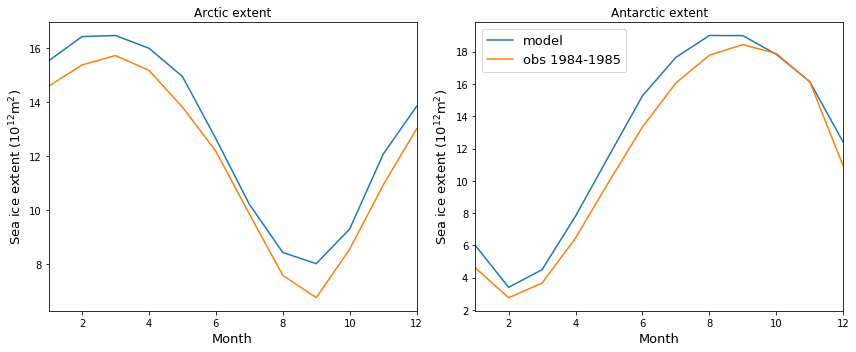

In [17]:
# Arctic seasonal cycle:
plt.figure(2,(12,5))
plt.clf()
plt.subplot(1,2,1)
plt.plot(np.arange(12)+1,ice_area_north_climatology/1e12,label = 'model')
plt.plot(np.arange(12)+1,NH_extent_climatology_obs)
plt.xlabel('Month',font)
plt.ylabel(r'Sea ice extent (10$^{12}$m$^2$)',font)
plt.xlim((1,12))
plt.title('Arctic extent') #, yrs '+str(last_year-(n_years-1))+'-'+str(last_year),font)

# Antarctic seasonal cycle:
plt.subplot(1,2,2)
plt.plot(np.arange(12)+1,ice_area_south_climatology/1e12,label = 'model')
plt.plot(np.arange(12)+1,SH_extent_climatology_obs,label="obs "+str(ext_firstyear)+"-"+str(ext_lastyear))
plt.xlabel('Month',font)
plt.ylabel(r'Sea ice extent (10$^{12}$m$^2$)',font)
plt.xlim((1,12))
plt.title('Antarctic extent') #, yrs '+str(last_year-(n_years-1))+'-'+str(last_year),font)
plt.legend(prop=font,loc=2)
plt.tight_layout()

savefigure('ice_extent')

## Climatologies

In [18]:
############################################
####### obs climatology:
# for obs just use years 1988-1997, because concentration not available before then and 
# climate change after then

conc_firstyear = 1988
conc_lastyear  = 1997

# NH All:
# CN_obs_NH = [[] for _ in range(12)]  # list keeps months separate
CN_obs_NH = [None]*12
for mo in tqdm_notebook(range(12), leave=False, desc='month'):
    # length of climatology:
    obs_list = [IceFile for IceFile in obsNHFileList if (IceFile.find(str(mo+1).zfill(2)+'_v0')>0 and 
        IceFile.find('nh_f')>0 and float(IceFile[-16:-12])>=conc_firstyear and \
        float(IceFile[-16:-12])<=conc_lastyear)] 
#     obs_list = [IceFile for IceFile in obsNHFileList if (IceFile.find(str(mo+1).zfill(2)+'_v0')>0 and 
#         IceFile.find('nh_f')>0 and float(IceFile[-16:-12])>1983 and \
#         float(IceFile[-16:-12])<1986)] 

    n_yrs = len(obs_list)
    for IceFile in tqdm_notebook(obs_list, leave=False, desc='year'):
    #     print('opening '+IceFile)
        ncFile = nc.Dataset(IceFile)
        tmp = ncFile.variables['seaice_conc_monthly_cdr'][0,...]
#         if len(CN_obs_NH[mo])==0:
        if CN_obs_NH[mo]==None:
            CN_obs_NH[mo] = tmp
        else:
            CN_obs_NH[mo] = CN_obs_NH[mo] + tmp
    # divide by n_yrs and mask land / arctic pole hole:
    CN_obs_NH[mo] = np.ma.masked_where(CN_obs_NH[mo]<0,CN_obs_NH[mo]) / n_yrs
    CN_obs_NH[mo] = np.ma.masked_where(CN_obs_NH[mo]>2,CN_obs_NH[mo])
obs_lat_NH = ncFile.variables['latitude'][...]
obs_lon_NH = ncFile.variables['longitude'][...]

HBox(children=(IntProgress(value=0, description='month', max=12), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/numpy/ma/core.py:3902: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  check = self.filled(0).__eq__(other)


HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

In [19]:
# SH All:
CN_obs_SH = [None]*12
for mo in tqdm_notebook(range(12), leave=False, desc='month'):
    # length of climatology:
    obs_list = [IceFile for IceFile in obsSHFileList if (IceFile.find(str(mo+1).zfill(2)+'_v0')>0 and 
        IceFile.find('sh_f')>0 and float(IceFile[-16:-12])>=conc_firstyear and \
        float(IceFile[-16:-12])<=conc_lastyear)] 
    n_yrs = len(obs_list)
    for IceFile in tqdm_notebook(obs_list, leave=False, desc='year'):
    #     print('opening '+IceFile)
        ncFile = nc.Dataset(IceFile)
        tmp = ncFile.variables['seaice_conc_monthly_cdr'][0,...]
        if CN_obs_SH[mo]==None:
            CN_obs_SH[mo] = tmp
        else:
            CN_obs_SH[mo] = CN_obs_SH[mo] + tmp
    # divide by n_yrs and mask land / arctic pole hole:
    CN_obs_SH[mo] = np.ma.masked_where(CN_obs_SH[mo]<0,CN_obs_SH[mo]) / n_yrs
    CN_obs_SH[mo] = np.ma.masked_where(CN_obs_SH[mo]>2,CN_obs_SH[mo])
obs_lat_SH = ncFile.variables['latitude'][...]
obs_lon_SH = ncFile.variables['longitude'][...]

HBox(children=(IntProgress(value=0, description='month', max=12), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/numpy/ma/core.py:3902: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  check = self.filled(0).__eq__(other)


HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='year', max=10), HTML(value='')))

In [15]:
# monthly ice concentration climatologies

CN_Feb = 0
CN_Mar = 0
CN_Sep = 0

CN_Sep_years = [[] for _ in range(n_years)]

# Feb (Antarctic only)
for IceFile in [f for f in dataFileList[firstfile:firstfile+n_files] if f.endswith('-02.nc')]:
#     print('opening '+IceFile)
    ncFile = nc.Dataset(IceFile)
    CN_Feb = CN_Feb + ncFile.variables['aice_m'][0,:NLAT_half,:]

# March (Arctic only)
for IceFile in [f for f in dataFileList[firstfile:firstfile+n_files] if f.endswith('-03.nc')]:
#     print('opening '+IceFile)
    ncFile = nc.Dataset(IceFile)
    CN_Mar = CN_Mar + ncFile.variables['aice_m'][0,NLAT_half:,:]

# Sep (both)
for n,IceFile in enumerate([f for f in dataFileList[firstfile:firstfile+n_files] if f.endswith('-09.nc')]):
#     print('opening '+IceFile)
    ncFile = nc.Dataset(IceFile)
#     CN_Sep_years[n] = np.append(CN_Sep_years, ncFile.variables['aice_m'][0,:,:])
    CN_Sep_years[n] = ncFile.variables['aice_m'][0,:,:]
    CN_Sep = CN_Sep + CN_Sep_years[n]
    CN_Sep_years[n] = np.ma.masked_where(land_mask==1,CN_Sep_years[n])

# divide by n_years and mask:
CN_Feb = np.ma.masked_where(land_mask[:NLAT_half,:]==1,CN_Feb / n_years)
CN_Mar = np.ma.masked_where(land_mask[NLAT_half:,:]==1,CN_Mar / n_years)
CN_Sep = np.ma.masked_where(land_mask==1,CN_Sep / n_years)


In [16]:
levels = np.arange(0,1.01,.01)
font = {'size':13}
tick_font=13

### Arctic model concentration maps, Sept and March

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


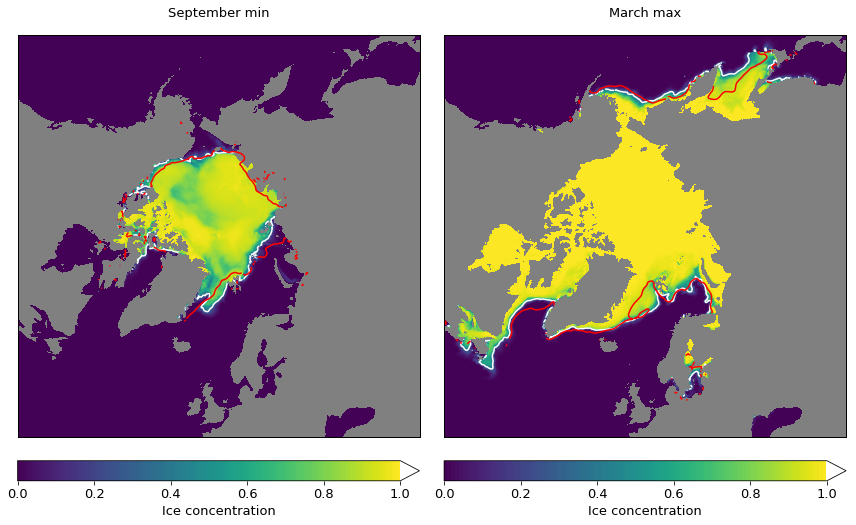

In [17]:
plt.figure(4,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
xobs,yobs = m(*(obs_lon_NH,obs_lat_NH))
ctr = m.contourf(x,y,CN_Sep[NLAT_half:,:],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September min',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[NLAT_half:,:],[0.3],colors='w')
# obs:
# m.contour(xobs,yobs,CN_obs_Sep_NH,[0.3],colors='r')
m.contour(xobs,yobs,CN_obs_NH[9-1],[0.3],colors='r')


plt.subplot(1,2,2)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(x,y,CN_Mar,levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('March max, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('March max',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Mar,[0.3],colors='w')
# obs:
# m.contour(xobs,yobs,CN_obs_Mar_NH,[0.3],colors='r')
m.contour(xobs,yobs,CN_obs_NH[3-1],[0.3],colors='r')


plt.tight_layout()

savefigure('Arctic_concentration_map')

### Arctic model and obs concentration maps, Sept

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


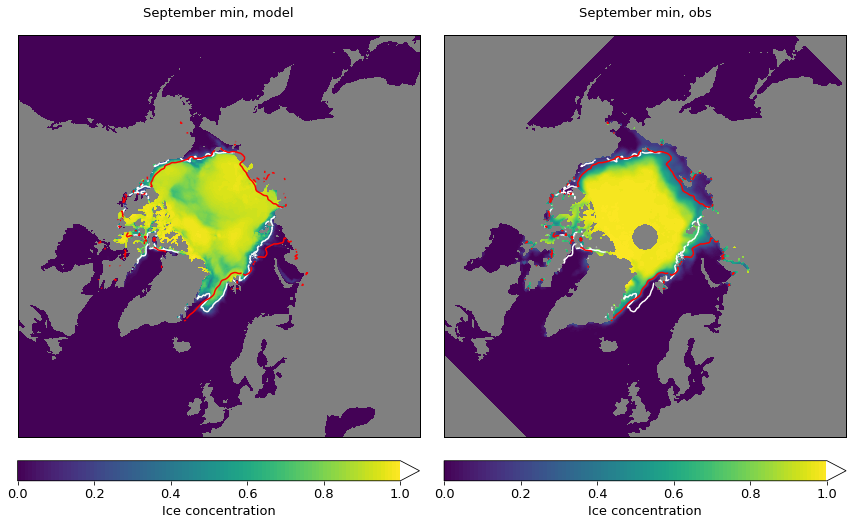

In [18]:
plt.figure(4,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
xobs,yobs = m(*(obs_lon_NH,obs_lat_NH))
ctr = m.contourf(x,y,CN_Sep[NLAT_half:,:],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September min, model',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[NLAT_half:,:],[0.3],colors='w')
# obs:
# m.contour(xobs,yobs,CN_obs_Sep_NH,[0.3],colors='r')
m.contour(xobs,yobs,CN_obs_NH[9-1],[0.3],colors='r')


plt.subplot(1,2,2)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(xobs,yobs,CN_obs_NH[9-1],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('March max, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September min, obs',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[NLAT_half:,:],[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_NH[9-1],[0.3],colors='r')

plt.tight_layout()

savefigure('Arctic_concentration_map_Sep')

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


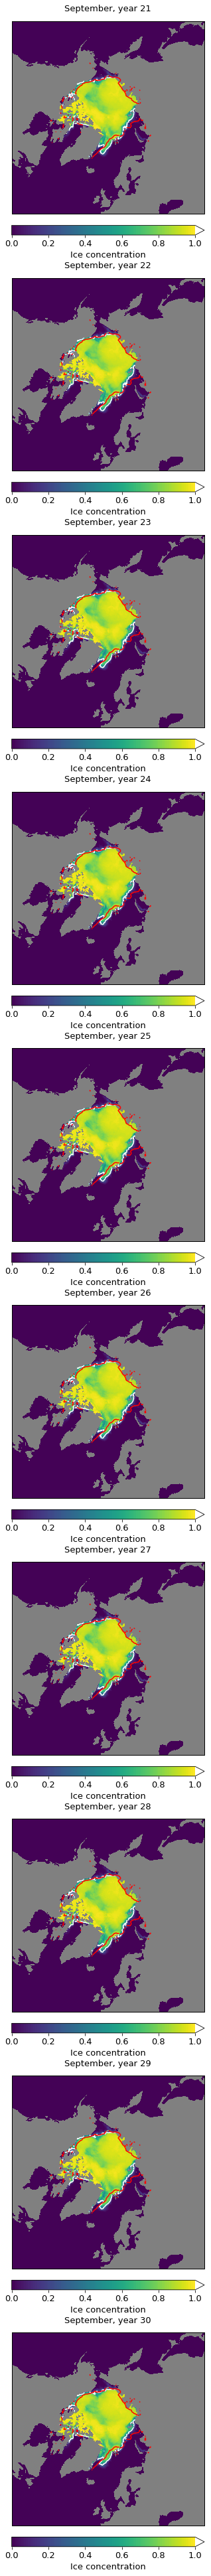

In [19]:
plt.figure(4,(12,7*n_years))
plt.clf()

# TODO: check that the CN_Sep_years list elements are not identical

for n in tqdm_notebook(range(n_years), leave=False):
    year = int(int(total_years)-n_years+n+1)
    plt.subplot(n_years,1,n+1)
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
    xobs,yobs = m(*(obs_lon_NH,obs_lat_NH))
    ctr = m.contourf(x,y,CN_Sep_years[n][NLAT_half:,:],levels=levels,cmap='viridis', extend='max')
    ctr.cmap.set_over(color='w', alpha=None)
    # plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
    # 	str(last_year),font,y=1.03)
    plt.title('September, year '+str(year),font,y=1.03)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice concentration',size=tick_font)
    cbar.set_ticks([0,.2,.4,.6,.8,1])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    #m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
    m.contour(x,y,CN_Sep_years[n][NLAT_half:,:],[0.3],colors='w')
    # obs:
#     m.contour(xobs,yobs,CN_obs_Sep_NH,[0.3],colors='r')
    m.contour(xobs,yobs,CN_obs_NH[9-1],[0.3],colors='r')

### Arctic model and obs concentration maps, March

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


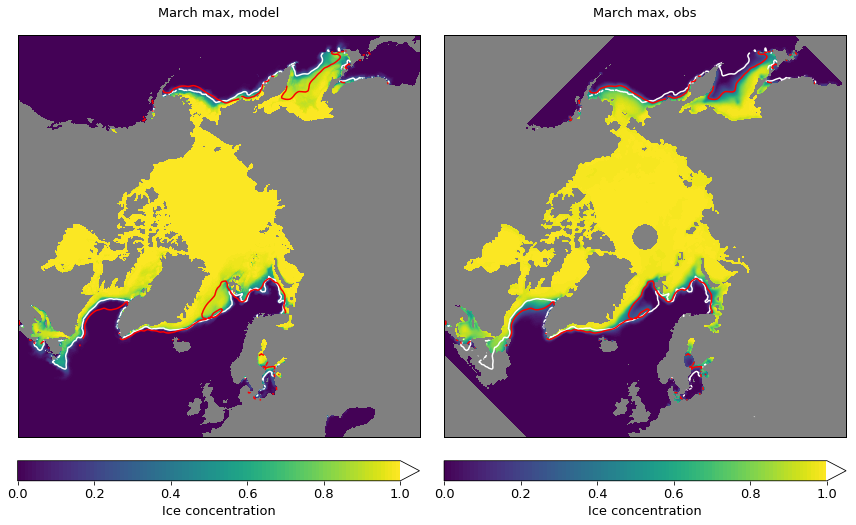

In [20]:
plt.figure(4,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
xobs,yobs = m(*(obs_lon_NH,obs_lat_NH))
ctr = m.contourf(x,y,CN_Mar,levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('March max, model',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Mar,[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_NH[3-1],[0.3],colors='r')

plt.subplot(1,2,2)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(xobs,yobs,CN_obs_NH[3-1],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('March max, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('March max, obs',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Mar,[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_NH[3-1],[0.3],colors='r')

plt.tight_layout()

savefigure('Arctic_concentration_map_Mar')

### Antarctic model and obs concentration maps

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


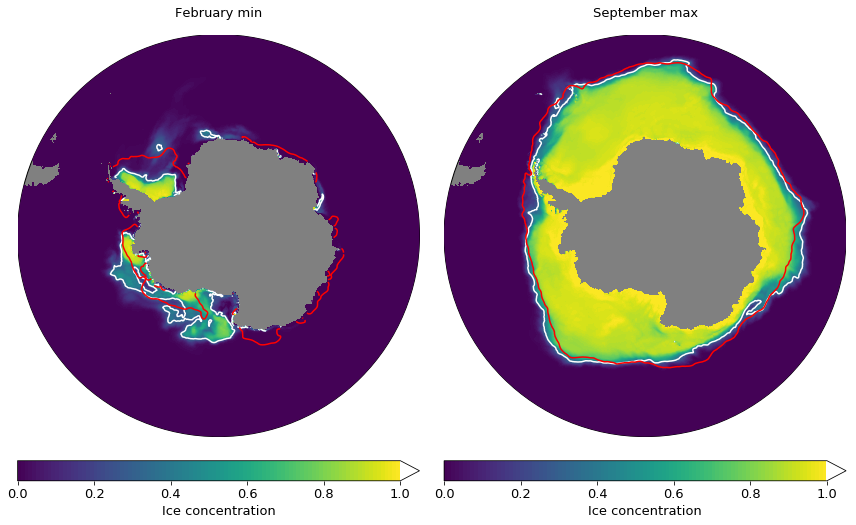

In [21]:
plt.figure(3,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='spstere',boundinglat=-50,lon_0=180,resolution='l',round='True')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[:NLAT_half,:],lat_t[:NLAT_half,:]))
xobs,yobs = m(*(obs_lon_SH,obs_lat_SH))
ctr = m.contourf(x,y,CN_Feb,levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('February min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('February min',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Feb,[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[2-1],[0.3],colors='r')

plt.subplot(1,2,2)
m = Basemap(projection ='spstere',boundinglat=-50,lon_0=180,resolution='l',round='True')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(x,y,CN_Sep[:NLAT_half,:],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('September max, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September max',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[:NLAT_half,:],[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[9-1],[0.3],colors='r')

plt.tight_layout()

savefigure('Antarctic_concentration_map')

### Antarctic model and obs concentration maps, Feb

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


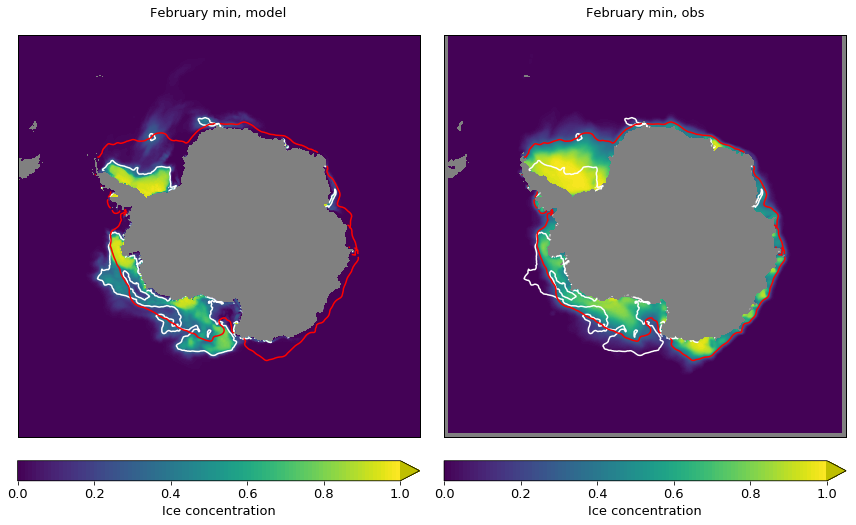

In [22]:
plt.figure(4,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[:NLAT_half,:],lat_t[:NLAT_half,:]))
xobs,yobs = m(*(obs_lon_SH,obs_lat_SH))
ctr = m.contourf(x,y,CN_Feb,levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='y', alpha=None)
# plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('February min, model',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Feb,[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[3-1],[0.3],colors='r')

plt.subplot(1,2,2)
m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(xobs,yobs,CN_obs_SH[3-1],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='y', alpha=None)
# plt.title('February min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('February min, obs',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Feb,[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[3-1],[0.3],colors='r')

plt.tight_layout()

savefigure('Antarctic_concentration_map_Feb')

### Antarctic model and obs concentration maps, Sep

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


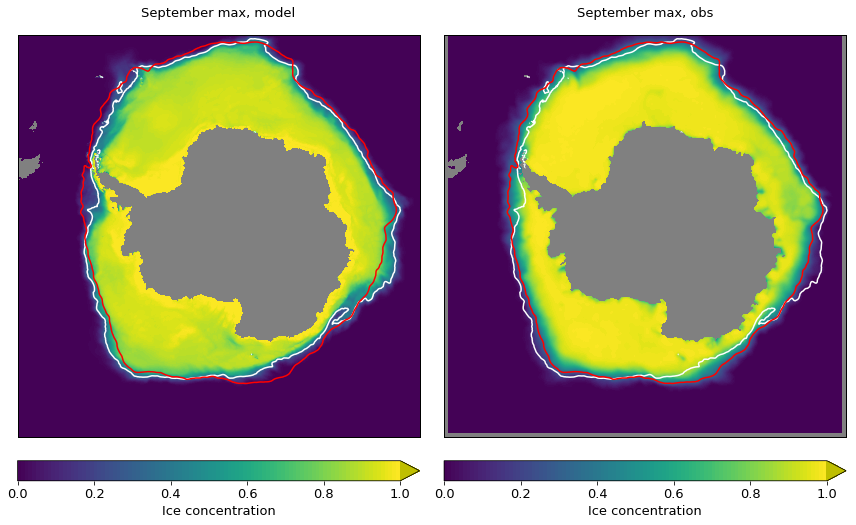

In [23]:
plt.figure(4,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[:NLAT_half,:],lat_t[:NLAT_half,:]))
xobs,yobs = m(*(obs_lon_SH,obs_lat_SH))
ctr = m.contourf(x,y,CN_Sep[:NLAT_half,:],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='y', alpha=None)
# plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September max, model',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[:NLAT_half,:],[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[9-1],[0.3],colors='r')

plt.subplot(1,2,2)
m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(xobs,yobs,CN_obs_SH[9-1],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='y', alpha=None)
# plt.title('September max, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September max, obs',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[:NLAT_half,:],[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[9-1],[0.3],colors='r')

plt.tight_layout()

savefigure('Antarctic_concentration_map_Sep')

## Thickness maps

In [24]:
# Arctic
months = [9, 12, 3, 6]  # which months to plot (Jan=1)
one_plot = False  # True: one file with many panels; False: many one-panel files

if one_plot:
    plt.figure(4,(8*len(months),8*n_years))
else:
    plt.figure(4,(8,8))

plt.clf()

time = []
mo = 0
for month in tqdm_notebook(months, leave=False):
    n = 0
    for IceFile in tqdm_notebook([f for f in dataFileList[firstfile:firstfile+n_files] if f.endswith('-'+str(month).zfill(2)+'.nc')], leave=False):
        year = int(int(total_years)-n_years+n+1)
        ncFile = nc.Dataset(IceFile)
        HI = ncFile.variables['hi_m'][0,...]
        if one_plot:
            plt.subplot(n_years,len(months),n*len(months)+mo+1)
        m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
        m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
        x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
        xobs,yobs = m(*(obs_lon_NH,obs_lat_NH))
        ctr = m.contourf(x,y,HI[NLAT_half:,:],levels=np.arange(0,7.1,.1),cmap='viridis', extend='max')
        ctr.cmap.set_over(color='w', alpha=None)
        plt.title(month_abbr[month]+' year '+str(year),font,y=1.03)
        cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
        cbar.set_label('Ice thickness (m)',size=tick_font)
        cbar.set_ticks(range(8))
        cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
        plt.setp(cbar_labels,fontsize=tick_font)
        # obs:
        m.contour(xobs,yobs,CN_obs_NH[month-1],[0.3],colors='r')
#         plt.tight_layout()
        if not(one_plot):
            savefigure('Arctic_thickness_map_month_'+str(month).zfill(2)+'_year_'+str(year).zfill(4))
            plt.close()
            plt.figure(4,(8,8))
        n = n + 1  # enumerate doesn't work with tqdm
    mo = mo + 1  # enumerate doesn't work with tqdm
if one_plot:
#     plt.tight_layout()
    savefigure('Arctic_thickness_maps')



HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

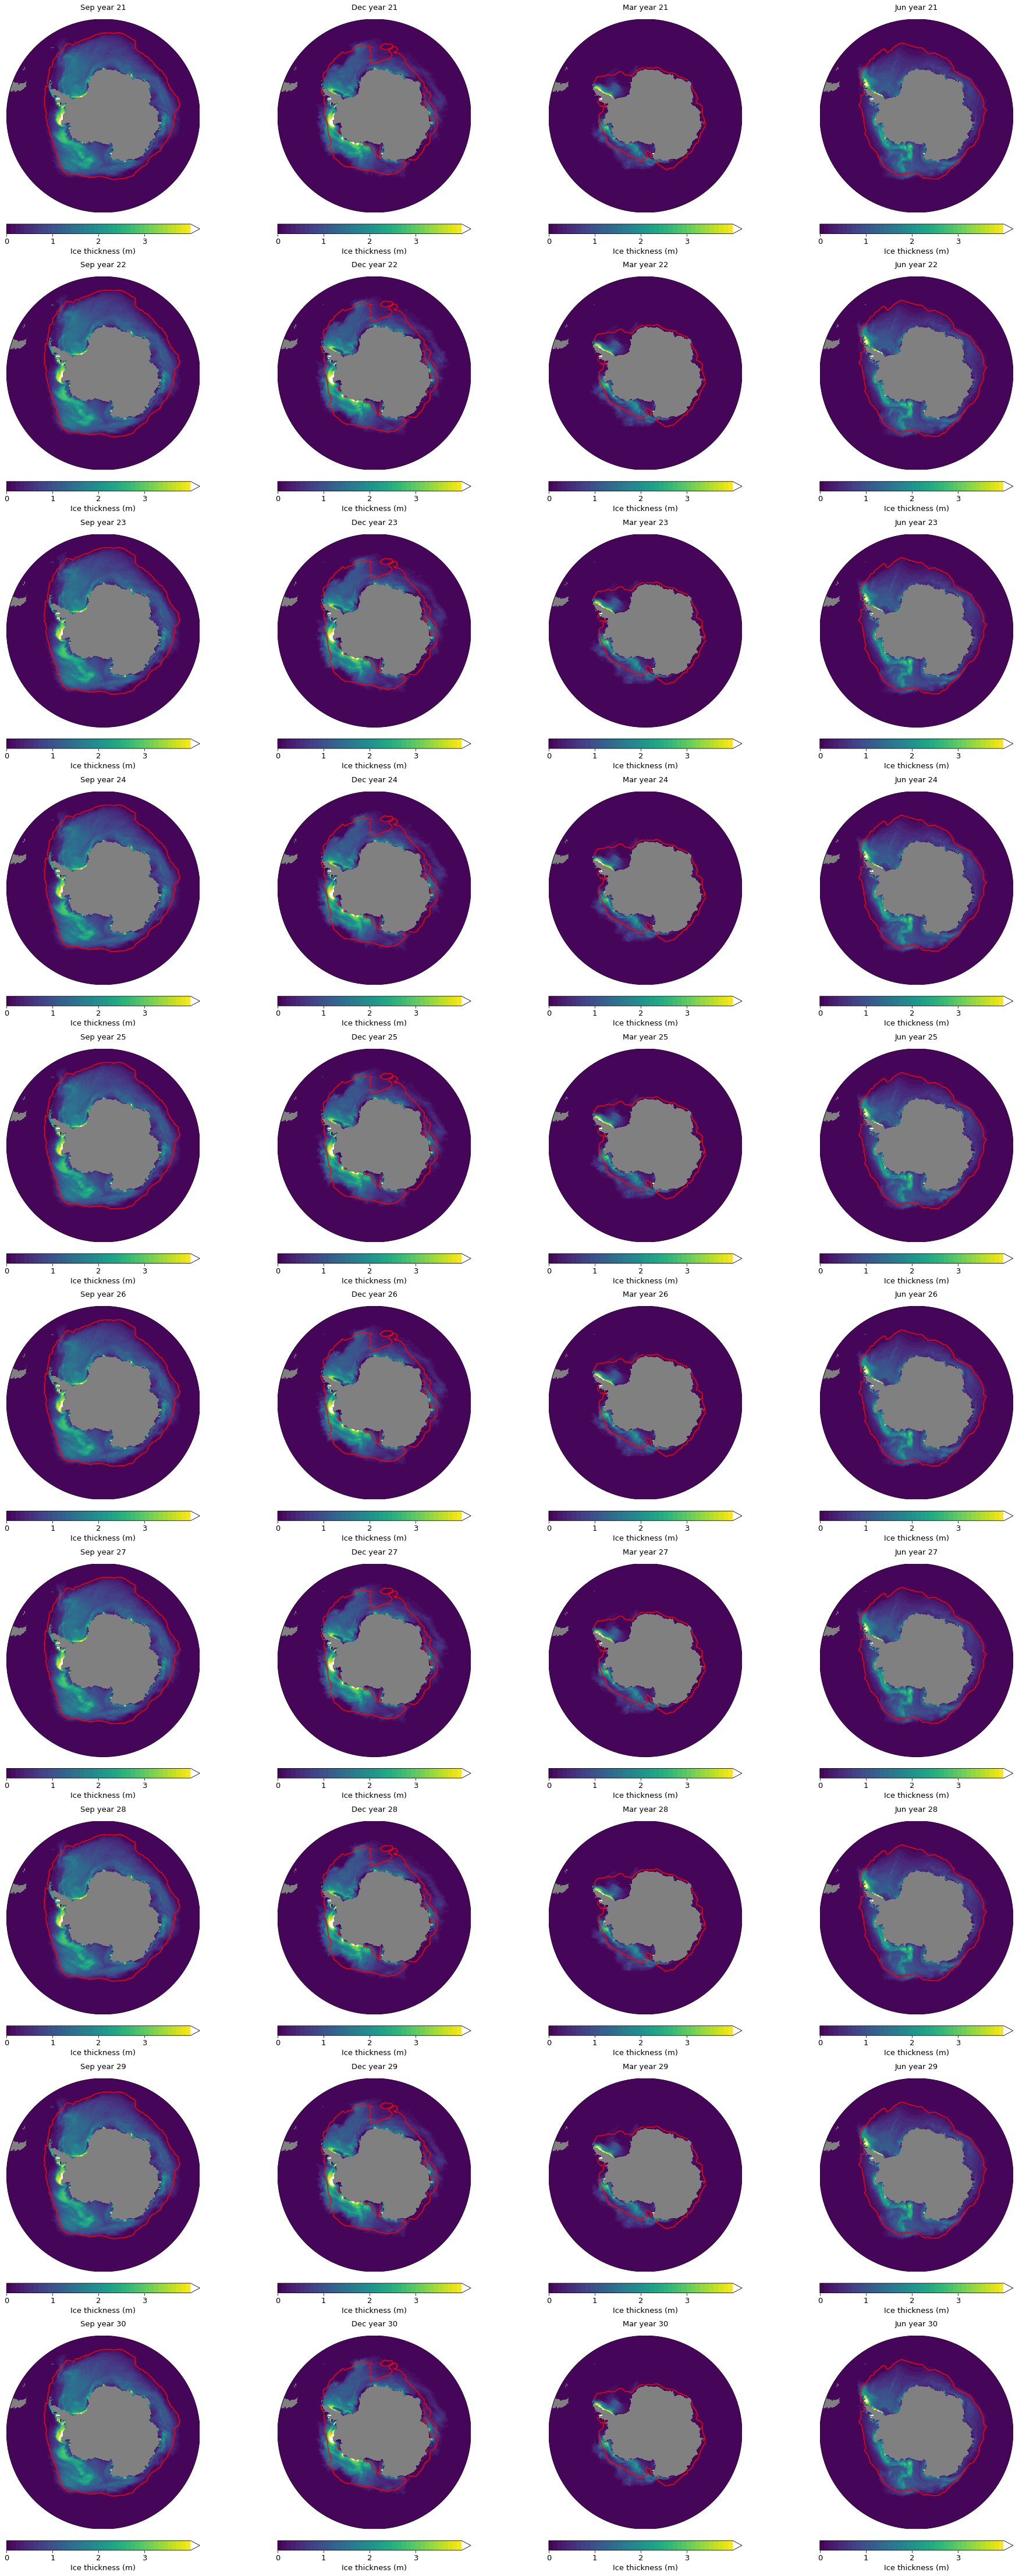

In [25]:
# Antarctic
months = [9, 12, 3, 6]  # which months to plot (Jan=1)
one_plot = True  # True: one file with many panels; False: many one-panel files

if one_plot:
    plt.figure(4,(8*len(months),8*n_years))
else:
    plt.figure(4,(8,8))

plt.clf()

time = []
mo = 0
for month in tqdm_notebook(months, leave=False):
    n = 0
    for IceFile in tqdm_notebook([f for f in dataFileList[firstfile:firstfile+n_files] if f.endswith('-'+str(month).zfill(2)+'.nc')], leave=False):
        year = int(int(total_years)-n_years+n+1)
        ncFile = nc.Dataset(IceFile)
        HI = ncFile.variables['hi_m'][0,...]
        if one_plot:
            plt.subplot(n_years,len(months),n*len(months)+mo+1)
#         m = Basemap(projection ='spstere',boundinglat=-55,lon_0=0,resolution='l')
        m = Basemap(projection ='spstere',boundinglat=-50,lon_0=180,resolution='l',round='True')
        m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
        x,y = m(*(lon_t[:NLAT_half,:],lat_t[:NLAT_half,:]))
        xobs,yobs = m(*(obs_lon_SH,obs_lat_SH))
        ctr = m.contourf(x,y,HI[:NLAT_half,:],levels=np.arange(0,4.1,.1),cmap='viridis', extend='max')
        ctr.cmap.set_over(color='w', alpha=None)
        plt.title(month_abbr[month]+' year '+str(year),font,y=1.03)
        cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
        cbar.set_label('Ice thickness (m)',size=tick_font)
        cbar.set_ticks(range(4))
        cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
        plt.setp(cbar_labels,fontsize=tick_font)
        # obs:
        m.contour(xobs,yobs,CN_obs_SH[month-1],[0.3],colors='r')
#         plt.tight_layout()
        if not(one_plot):
            savefigure('Antarctic_thickness_map_month_'+str(month).zfill(2)+'_year_'+str(year).zfill(4))
            plt.close()
            plt.figure(4,(8,8))
        n = n + 1  # enumerate doesn't work with tqdm
    mo = mo + 1  # enumerate doesn't work with tqdm
if one_plot:
#     plt.tight_layout()
    savefigure('Antarctic_thickness_maps')



# REDUNDANT - set to raw to disable execution

## Sea ice volume timeseries